In [1]:
import fastjet as fj
import pythia8
from recursivetools import pyrecursivetools as rt
from lundplane import pylundplane as lund
from pythiafjtools import pypythiafjtools as pyfj
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
from tqdm import tnrange, tqdm_notebook
import joblib
import os

In [4]:
def deltas(jets, jets0):
    for i in range(len(jets)):
        yield jets0[i].perp() - jets[i].perp()

def create_and_init_pythia(config_strings=[]):
    pythia = pythia8.Pythia()
    for s in config_strings:
        pythia.readString(s)
    for extra_s in ["Next:numberShowEvent = 0", "Next:numberShowInfo = 0", "Next:numberShowProcess = 0"]:
        pythia.readString(extra_s)
    if pythia.init():
        return pythia
    return None

sconfig_pythia = [ "Beams:eCM = 8000.", "HardQCD:all = on", "PhaseSpace:pTHatMin = 100."]
pythia = create_and_init_pythia(sconfig_pythia)

# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
jet_selector = fj.SelectorPtMin(100.0) & fj.SelectorPtMax(200.0) & fj.SelectorAbsEtaMax(1)
sd = rt.SoftDrop(0, 0.1, 1.0)

In [ ]:
all_jets = []
for iEvent in tqdm_notebook(range(10000), 'event'):
    if not pythia.next(): continue
    parts = pyfj.vectorize(pythia, True, -1, 1, False)
    jets = jet_selector(jet_def(parts))
    all_jets.extend(jets)

In [6]:
jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = lund.LundGenerator(jet_def_lund)

In [7]:
%%time
lunds = [lund_gen.result(j) for j in all_jets]

CPU times: user 18.2 ms, sys: 4.25 ms, total: 22.4 ms
Wall time: 21.6 ms


In [8]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 23.5 ms, sys: 1.5 ms, total: 25 ms
Wall time: 24 ms


(array([[1., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.90840095, 0.96583683, 1.02327271, 1.0807086 , 1.13814448,
        1.19558036, 1.25301624, 1.31045213, 1.36788801, 1.42532389,
        1.48275977, 1.54019566, 1.59763154, 1.65506742, 1.7125033 ,
        1.76993919, 1.82737507, 1.88481095, 1.94224683, 1.99968272,
        2.0571186 , 2.11455448, 2.17199037, 2.22942625, 2.28686213,
        2.34429801, 2.4017339 , 2.45916978, 2.51660566, 2.57404154,
        2.63147743, 2.68891331, 2.74634919, 2.80378507, 2.86122096,
        2.91865684, 2.97609272, 3.0335286 , 3.09096449, 3.14840037,
        3.20583625, 3.26327213, 3.32070802, 3.3781439 , 3.43557978,
        3.49301566, 3.55045155, 3.60788743, 3.66532331, 3.72275919,
        3.78019508, 3.83763096, 3.89506684, 3.95250272, 4.00993861,
   

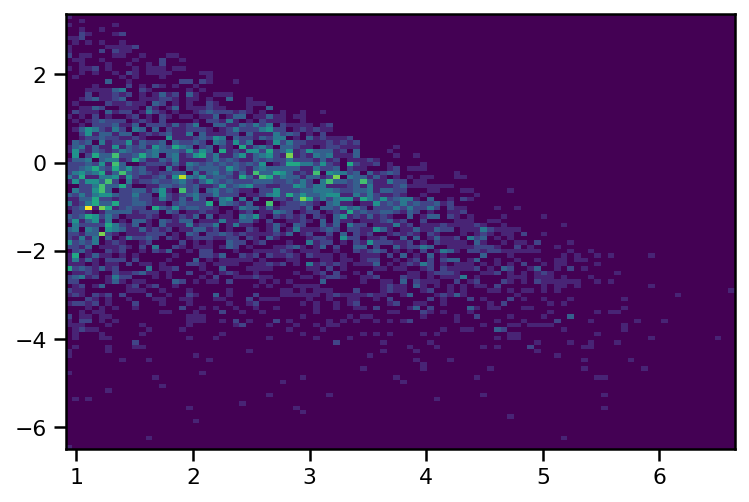

In [9]:
plt.hist2d(log_1oDelta, log_kt, bins=100)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 4., 2., 2.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.673456  , 0.75306704, 0.83267807, 0.91228911, 0.99190014,
        1.07151117, 1.15112221, 1.23073324, 1.31034428, 1.38995531,
        1.46956634, 1.54917738, 1.62878841, 1.70839945, 1.78801048,
        1.86762152, 1.94723255, 2.02684358, 2.10645462, 2.18606565,
        2.26567669, 2.34528772, 2.42489875, 2.50450979, 2.58412082,
        2.66373186, 2.74334289, 2.82295393, 2.90256496, 2.98217599,
        3.06178703, 3.14139806, 3.2210091 , 3.30062013, 3.38023116,
        3.4598422 , 3.53945323, 3.61906427, 3.6986753 , 3.77828634,
        3.85789737, 3.9375084 , 4.01711944, 4.09673047, 4.17634151,
        4.25595254, 4.33556358, 4.41517461, 4.49478564, 4.57439668,
        4.65400771, 4.73361875, 4.81322978, 4.89284081, 4.97245185,
   

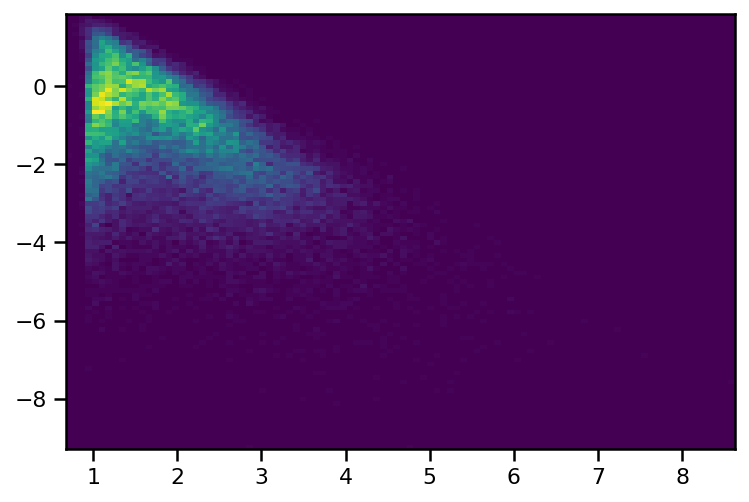

In [13]:
if not os.path.exists('test_lund_2d.joblib'):
    joblib.dump([log_1oDelta, log_kt], 'test_lund_2d.joblib') 
xy = joblib.load('test_lund_2d.joblib')
plt.hist2d(xy[0], xy[1], bins=100)